In [33]:
import glob
import os
import typing
from tensorflow import keras
import tqdm
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

image_shape = (250, 250, 3)
number_of_images = 200

In [35]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):  # if value ist tensor
        value = value.numpy()  # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a floast_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

In [36]:
def generate_random_full_colour_images(n, image_shape):
    red = (255, 0, 0)
    green = (0, 255, 0)
    blue = (0, 0, 255)
    colours = {0: red, 1: green, 2: blue}
    generated_images = []
    generated_labels = []
    for _ in range(n):
        label = np.random.randint(0, 3, size=None)
        img = Image.new('RGB', image_shape[:-1], colours[label])
        generated_images.append(np.asarray(img))
        generated_labels.append(label)

    return np.asarray(generated_images), np.asarray(generated_labels)

In [37]:
images, labels = generate_random_full_colour_images(number_of_images, image_shape=image_shape)
print(images.shape)
print(labels.shape)

(200, 250, 250, 3)
(200,)


In [38]:
def parse_single_image(image, label):
    #define the dictionary -- the structure -- of our single example
    data = {
        'height': _int64_feature(image.shape[0]),
        'width': _int64_feature(image.shape[1]),
        'depth': _int64_feature(image.shape[2]),
        'raw_image': _bytes_feature(serialize_array(image)),
        'label': _int64_feature(label)
    }

    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [39]:
def write_images_to_tfr(images, labels, filename: str = "images", max_files: int = 10,
                        out_dir: str = "./tfrecords/"):
    os.makedirs(out_dir, exist_ok=True)
    #determine the number of shards (single TFRecord files) we need:
    splits = (len(images) // max_files) + 1  #determine how many tfr shards are needed
    if len(images) % max_files == 0:
        splits -= 1
    print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

    file_count = 0

    for i in tqdm.tqdm(range(splits)):
        current_shard_name = "{}{}_{}{}.tfrecords".format(out_dir, i + 1, splits, filename)
        writer = tf.io.TFRecordWriter(current_shard_name)

        current_shard_count = 0
        while current_shard_count < max_files:  #as long as our shard is not full
            #get the index of the file that we want to parse now
            index = i * max_files + current_shard_count
            if index == len(images):  #when we have consumed the whole data, preempt generation
                break

            current_image = images[index]
            current_label = labels[index]

            #create the required Example representation
            out = parse_single_image(image=current_image, label=current_label)

            writer.write(out.SerializeToString())
            current_shard_count += 1
            file_count += 1

        writer.close()
    print(f"\nWrote {file_count} elements to TFRecord")
    return file_count

In [40]:
count = write_images_to_tfr(images, labels, filename="images", max_files=20)


Using 10 shard(s) for 200 files, with up to 20 samples per shard


100%|██████████| 10/10 [00:00<00:00, 34.44it/s]


Wrote 200 elements to TFRecord


In [41]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'raw_image': tf.io.FixedLenFeature([], tf.string),
        'depth': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    label = content['label']
    raw_image = content['raw_image']

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
    feature = tf.reshape(feature, shape=[height, width, depth])
    return (feature, label)

In [42]:
def get_dataset(tfr_dir: str = "/content/", pattern: str = "*images.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)
    print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(
        parse_tfr_element
    )

    return dataset

In [43]:
dataset = get_dataset("./tfrecords")
dataset = dataset.batch(32)
dataset = dataset.map(lambda x, y:(tf.cast(x, tf.float32)/255.0, y))

['./tfrecords/3_10images.tfrecords', './tfrecords/10_10images.tfrecords', './tfrecords/5_10images.tfrecords', './tfrecords/8_10images.tfrecords', './tfrecords/6_10images.tfrecords', './tfrecords/7_10images.tfrecords', './tfrecords/4_10images.tfrecords', './tfrecords/9_10images.tfrecords', './tfrecords/2_10images.tfrecords', './tfrecords/1_10images.tfrecords']


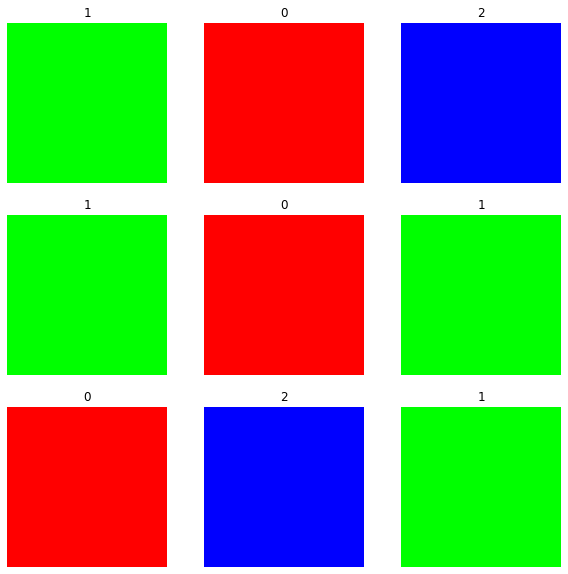

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")
plt.savefig("three_color_dataset_sample")

In [45]:
def get_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))

    return model

In [19]:
model = get_model(image_shape)

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = keras.metrics.SparseCategoricalAccuracy()
optimizer = keras.optimizers.Adam()

In [21]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [22]:
model.fit(dataset, epochs=5)

Epoch 1/5


2022-03-13 12:45:35.987541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 169ms/step - loss: 0.7281 - sparse_categorical_accuracy: 0.8050
Epoch 2/5
7/7 [==============================] - 1s 136ms/step - loss: 0.0249 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
7/7 [==============================] - 1s 148ms/step - loss: 6.4167e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
7/7 [==============================] - 1s 144ms/step - loss: 1.0424e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
7/7 [==============================] - 1s 140ms/step - loss: 9.1223e-07 - sparse_categorical_accuracy: 1.0000
